The purpose of this notebook is to look at how xGF and GF compare by team--are there some teams beating the expectations more than we'd think?

Data from [Corsica](http://corsica.hockey/team-stats/?season=20172018,20162017,20152016,20142015,20132014,20122013,20112012,20102011,20092010,20082009,20072008&team=&game_state=5v5&options=Adjust&session=Regular&venue=Any&report=Summary&tab=Main
), 5v5 only, and [adjusted](http://www.corsica.hockey/blog/2016/06/19/adjustments-explained/) (which I'll assume gives the best picture here--but it's possible it may not).

In [1]:
import pandas as pd
from pylab import *
%matplotlib inline

# Exported and downloaded 5v5 data
df = pd.read_csv('C://Users//Muneeb Alam//Downloads//team_stats_2018-01-03.csv')
df = df[['Team', 'Season', 'GF', 'xGF', 'GA', 'xGA']]

# Calculate goals above and below expected
df.loc[:, 'Goals above expected'] = df.GF - df.xGF
df.loc[:, 'Goals against below expected'] = df.GA - df.xGA

# Change seasons to numbers
df.loc[:, 'Season'] = df.Season.apply(lambda x: int(x[:4]))

# Change ATL to WPG
df.loc[:, 'Team'] = df.Team.apply(lambda x: 'WPG' if x == 'ATL' else x)
df.head()

,Team,Season,GF,xGF,GA,xGA,Goals above expected,Goals against below expected
0,ANA,2007,102.53,104.35,90.54,109.55,-1.82,-19.01
1,ANA,2008,138.35,129.44,123.57,123.60,8.91,-0.03
2,ANA,2009,137.55,126.01,135.02,148.35,11.54,-13.33
3,ANA,2010,128.90,117.52,147.57,148.63,11.38,-1.06
4,ANA,2011,131.38,128.21,147.32,143.27,3.17,4.05


First, it's good to look at the distribution of goals above expected (excluding 2012-13 and the current year).

It's not centered at zero--I don't know why that is. (Maybe related to adjustments?) There have been ~1k more goals scored than expected (a deficit of ~2.5%). The median difference is ~3 goals. 

It's small enough that I feel comfortable ignoring it (and the methodology I use here shouldn't need a zero-centered distribution).

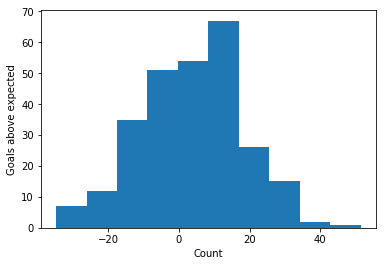

In [2]:
hist(df.query('Season != 2012 & Season != 2017')['Goals above expected'])
xlabel('Count')
ylabel('Goals above expected')

We can use a dotplot to go team-by-team and see if any consistently exceed expectations.

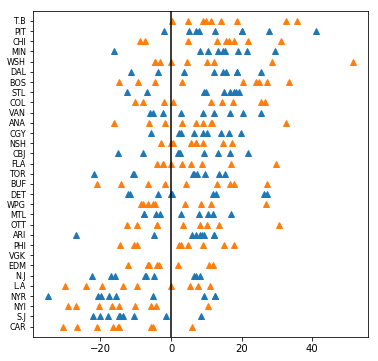

In [3]:
# Sort by sum of goals above expected
f = figure(figsize=[6, 6])
order = df[['Team', 'Goals above expected']].groupby('Team', as_index=False).sum() \
    .sort_values('Goals above expected') \
    .assign(Order=1)
order.loc[:, 'Order'] = order.Order.cumsum()
df2 = df.merge(order[['Team', 'Order']], how='inner', on='Team') \
    .query('Season != 2012 & Season != 2017')
for i in range(2):
    tmp = df2[df2.Order % 2 == i]
    plot(tmp['Goals above expected'], tmp.Order, marker='^', ls='None')
plot([0, 0], [0, 32], color='k')
ylim(0, 32)
yticks(order.Order, order.Team, fontsize=8);

Intuitively, with 30-odd teams, *some* will do unlikely things. But here, there are quite a few.

There are nine seasons plotted here. Let's say we expected a team to be 50/50 to be above or below expectation in a given year. That puts Tampa Bay's performance (above expectation 9 times in 9 seasons) at around ~0.2% chance. Pittsburgh and Minnesota are in similar situations, as are Carolina, San Jose, and the Islanders. That's a lot of extremes--implying that something systemic could be at play here, too.

In other words, it seems like beating your expectation seems a little sustainable--which it shouldn't be.

Below, I plotted this distribution versus a simulation. If beating (or failing to beat) your expectation is sustainable, we should see "fat tails" since teams consistently at extremes will accumulate goals above expectation. We can see that at the top, and it's even more noticeable at the bottom.

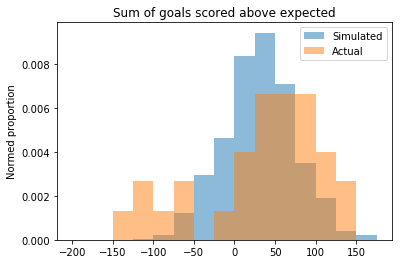

In [4]:
# Team distributions in these nine seasons

# Simulate a bunch of teams
# Find a random integer from 0 to 269 inclusive. Take that row's goals above expected from df2. Do this nine times.
# Repeat 1000 times
reps = 9 * 1000
xgd = [_ for i in range(reps)]
np.random.seed(8)
rows = [int(len(df2) * x) for x in np.random.random(size=reps)]
for i in range(len(rows)):
    xgd[i] = df2[['Goals above expected']].iloc[rows[i], 0]

# Sum over groups of 9
tmp = pd.DataFrame({'xGD': xgd}).assign(Row=1)
tmp.loc[:, 'Row'] = tmp.Row.cumsum()
tmp.loc[:, 'TeamSim'] = tmp.Row.apply(lambda x: x % int(reps/9))
tmp2 = tmp.groupby('TeamSim', as_index=False).sum()

# Plot
hist(tmp2.xGD, label='Simulated', bins=range(-200, 200, 25), alpha=0.5, normed=True)
hist(df2.groupby('Team').sum()['Goals above expected'], label='Actual', bins=range(-200, 200, 25), alpha=0.5, normed=True)
legend(loc=1)
title('Sum of goals scored above expected')
ylabel('Normed proportion')

My suspicion is that shooter, shot type, and shot location (along with *some* rush and rebound flagging) just isn't enough to get a good picture of shot quality. Expected goals are better than Fenwick, Corsi, scoring chances, etc, but it's worth keeping in mind that xG is still fallible and is not be as accurate as we'd like it to be. This is more and more true the finer and finer things get sliced.

There's one big gap we know about with xG models: east-west passes. Hopefully [the new tool](https://hockey-graphs.com/2018/01/02/an-introduction-to-new-tracking-technology/) can help remedy that. I'm sure there are other "hockey" things missing from xG as well.

Here's team-level information by year, with some teams I found notable bolded.

In [5]:
# List teams by old divisions--5 per plot is nice
divisions = {'ATL': ['PIT', 'PHI', 'NYR', 'NYI', 'N.J'],
            'NE': ['BOS', 'BUF', 'MTL', 'OTT', 'TOR'],
            'SE': ['WSH', 'WPG', 'CAR', 'T.B', 'FLA'],
            'CEN': ['DET', 'CHI', 'NSH', 'CBJ', 'STL'],
            'PAC': ['L.A', 'S.J', 'ARI', 'DAL', 'ANA'],
            'NW': ['VAN', 'CGY', 'EDM', 'MIN', 'COL']}

In [6]:
# Plot by division
def plot_div(div, *highlights):
    title('Old {0:s} division'.format(div))
    for team in divisions[div]:
        tmp = df.query('Team == "{0:s}"'.format(team))
        if team in highlights:
            lw = 3
            ls = '-'
        else:
            lw = 1
            ls = '--'
        plot(tmp['Season'], tmp['Goals above expected'], label=team, lw=lw, ls=ls)
        legend(loc=2, bbox_to_anchor=(1, 1))
        xlimits = xlim()
        plot(xlimits, [0, 0], color='k', lw=2)
        xlim(*xlimits)
        xlabel('GF - xGF')

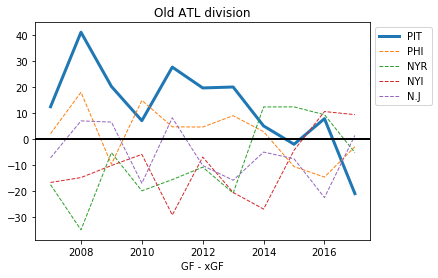

In [7]:
plot_div('ATL', 'PIT')

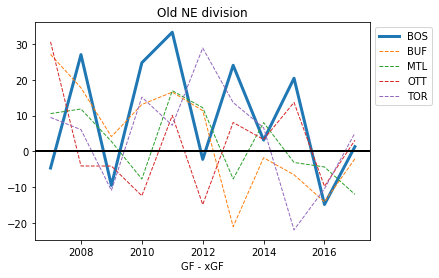

In [8]:
plot_div('NE', 'BOS')

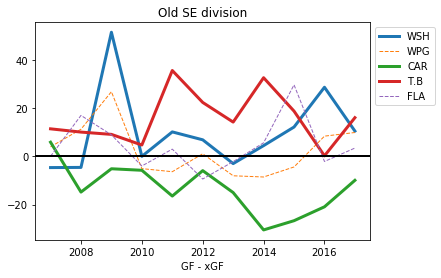

In [9]:
plot_div('SE', 'WSH', 'T.B', 'CAR')

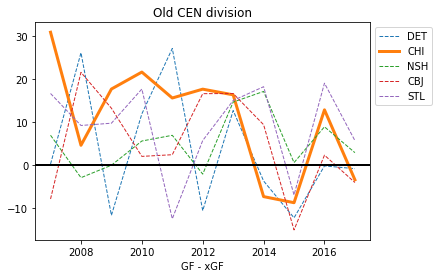

In [10]:
plot_div('CEN', 'CHI')

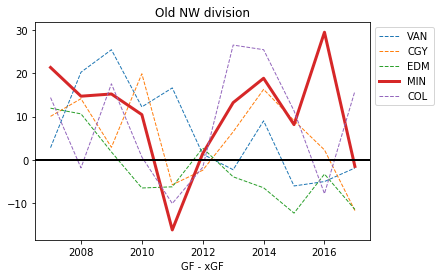

In [11]:
plot_div('NW', 'MIN')

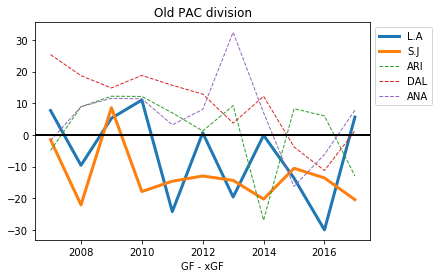

In [12]:
plot_div('PAC', 'L.A', 'S.J')